# Capture Wikipedia polling data and produce LOWESS charts

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-Wikipedia-polling-data" data-toc-modified-id="Get-Wikipedia-polling-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get Wikipedia polling data</a></span></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Check-raw-data-tallies-to-100%" data-toc-modified-id="Check-raw-data-tallies-to-100%-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check raw data tallies to 100%</a></span><ul class="toc-item"><li><span><a href="#Report-problematic-voting-intention-data" data-toc-modified-id="Report-problematic-voting-intention-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Report problematic voting intention data</a></span></li><li><span><a href="#Report-problematic-attitudinal-data" data-toc-modified-id="Report-problematic-attitudinal-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Report problematic attitudinal data</a></span></li></ul></li><li><span><a href="#Attribute-undecideds-(force-polls-to-sum-to-100-percent)" data-toc-modified-id="Attribute-undecideds-(force-polls-to-sum-to-100-percent)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Attribute undecideds (force polls to sum to 100 percent)</a></span></li><li><span><a href="#Calculate-2pp-based-on-preference-flows-at-the-2019-election" data-toc-modified-id="Calculate-2pp-based-on-preference-flows-at-the-2019-election-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculate 2pp based on preference flows at the 2019 election</a></span></li><li><span><a href="#Quick-plots" data-toc-modified-id="Quick-plots-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Quick plots</a></span><ul class="toc-item"><li><span><a href="#Plotting-constants" data-toc-modified-id="Plotting-constants-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Plotting constants</a></span></li><li><span><a href="#Plots-with-summary-lines-by-individual-pollsters" data-toc-modified-id="Plots-with-summary-lines-by-individual-pollsters-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Plots with summary lines by individual pollsters</a></span></li><li><span><a href="#All-poll-aggregations" data-toc-modified-id="All-poll-aggregations-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>All poll aggregations</a></span></li><li><span><a href="#Preferred-Prime-Minister" data-toc-modified-id="Preferred-Prime-Minister-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Preferred Prime Minister</a></span></li><li><span><a href="#Satisfaction-charts" data-toc-modified-id="Satisfaction-charts-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Satisfaction charts</a></span></li></ul></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save files</a></span></li><li><span><a href="#Check-for-any-problems-with-data-capture-and-cleaning" data-toc-modified-id="Check-for-any-problems-with-data-capture-and-cleaning-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Check for any problems with data capture and cleaning</a></span></li></ul></div>

## Python set-up

In [1]:
# data science imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

# web
import requests

# standard python imports
import platform, sys, os, pathlib
from io import StringIO
from typing import List
import time

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER, COLOR_GREEN
from common import P_COLOR_COALITION, P_COLOR_LABOR, P_COLOR_OTHER, P_COLOR_GREEN

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Apr 29 2022 12:35:25

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

matplotlib : 3.5.1
pandas     : 1.4.2
numpy      : 1.22.3
statsmodels: 0.13.2
requests   : 2.27.1
sys        : 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:24:38) 
[Clang 12.0.1 ]
platform   : 1.0.8

Watermark: 2.3.0



In [3]:
# pandas 
pd.set_option('display.max_rows', 1000)

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')
LFOOTER = 'Polling data from Wikipedia'

In [5]:
# saving downloaded files
DATA_DIR = '../data'
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
DATA_DIR += '/'

## Get Wikipedia polling data

In [6]:
def get_url_tables(url: str) -> str:
    headers = {
        'Cache-Control': 'no-cache, must-revalidate, private, max-age=0',
        'Pragma': 'no-cache',
    }
    r = requests.get(url.format(rn=time.time()), headers=headers)
    #print(r.headers)
    assert(r.status_code == 200) # successful retrieval
    text = r.text
    return pd.read_html(text)
    
WIKIURL = 'https://en.wikipedia.org/wiki/Opinion_polling_for_the_2022_Australian_federal_election'
table_list = get_url_tables(WIKIURL)

In [7]:
def extract_polling_tables(table_list):
    sought = {
        # description:              table numbers in table_list
        "Voting intention":         [1, 2],
        "Preferred prime minister": [3],
    }

    table_dict = {}
    for item, table_numbers in sought.items():
        captured = []
        returnable = None
        for table_number in table_numbers:
            table = table_list[table_number]
            returnable = table if returnable is None else pd.concat([returnable, table])
        table_dict[item] = returnable
    return table_dict

table_dict = extract_polling_tables(table_list)

In [8]:
# Web scraping is always a little fragile
# we check the tables extracted here:

for key, table in table_dict.items():
    print(f'{key} (length={len(table)})')
    display(table.iloc[:15])
    print('=' * 40)

Voting intention (length=151)


Date  \
                       Date   
0          18–24 April 2022   
1          20–23 April 2022   
2          20–23 April 2022   
3          19–20 April 2022   
4          11–17 April 2022   
5          14–17 April 2022   
6          11–16 April 2022   
7             10 April 2022   
8           4–10 April 2022   
9            6–9 April 2022   
10  31 March – 3 April 2022   
11  28 March – 3 April 2022   
12  31 March – 3 April 2022   
13  30 March – 2 April 2022   
14  30 March – 2 April 2022   

                                                Brand  \
                                                Brand   
0                                       Roy Morgan[6]   
1                                  Newspoll-YouGov[7]   
2                                            Ipsos[8]   
3                                        Essential[9]   
4                                      Roy Morgan[10]   
5                                 Newspoll-YouGov[11]   
6                               Resolve Strategic[12]   
7   Australian federal election campaign begins wi...   
8                                      Roy Morgan[13]   
9                                 Newspoll-YouGov[14]   
10                              Resolve Strategic[15]   
11                                     Roy Morgan[16]   
12                                Newspoll-YouGov[17]   
13                                      Essential[18]   
14                                          Ipsos[19]   

                                       Interview mode  \
                                       Interview mode   
0                                    Telephone/online   
1                                              Online   
2                                    Telephone/online   
3                                              Online   
4                                    Telephone/online   
5                                              Online   
6                                              Online   
7   Australian federal election campaign begins wi...   
8                                    Telephone/online   
9                                              Online   
10                                             Online   
11                                   Telephone/online   
12                                             Online   
13                                             Online   
14                                   Telephone/online   

                                          Sample size  \
                                          Sample size   
0                                                1393   
1                                                1538   
2                                                2302   
3                                                1052   
4                                                1382   
5                                                1510   
6                                                1404   
7   Australian federal election campaign begins wi...   
8                                                1384   
9                                                1506   
10                                               1681   
11                                               1367   
12                                               1531   
13                                               1086   
14                                               2563   

                                         Primary vote  \
                                                 L/NP   
0                                               35.5%   
1                                                 36%   
2                                                 32%   
3                                                 37%   
4                                               35.5%   
5                                                 35%   
6                                                 35%   
7   Australian federal election campaign begins wi...   
8              

Preferred prime minister (length=80)


Date                           Brand  \
         Unnamed: 0_level_1              Unnamed: 1_level_1   
0          20–23 April 2022                     Newspoll[7]   
1          20–23 April 2022                        Ipsos[8]   
2          17–20 April 2022                    Essential[9]   
3          11–16 April 2022   Resolve Political Monitor[12]   
4            6–9 April 2022                    Newspoll[14]   
5   31 March – 3 April 2022       Resolve Political Monitor   
6   31 March – 3 April 2022                        Newspoll   
7   31 March – 2 April 2022                           Ipsos   
8           9–12 March 2022                    Newspoll[24]   
9       23–26 February 2022                    Newspoll[27]   
10      17–20 February 2022                   Essential[30]   
11       9–12 February 2022                    Newspoll[32]   
12       27–30 January 2022                    Newspoll[34]   
13       20–23 January 2022                   Essential[30]   
14       11–15 January 2022  Resolve Political Monitor[123]   

                 Firm     Interview mode        Sample size  \
   Unnamed: 2_level_1 Unnamed: 3_level_1 Unnamed: 4_level_1   
0              YouGov   Telephone/Online               1538   
1               Ipsos   Telephone/Online               2302   
2           Essential             Online               1052   
3   Resolve Strategic             Online               1404   
4              YouGov             Online               1506   
5   Resolve Strategic             Online               1681   
6              YouGov             Online               1531   
7               Ipsos   Telephone/Online               2563   
8              YouGov             Online               1520   
9              YouGov             Online               1525   
10          Essential             Online               1089   
11             YouGov             Online               1526   
12             YouGov             Online               1523   
13          Essential             Online               1001   
14  Resolve Strategic             Online               1607   

   Preferred Prime Minister                      Morrison               \
                   Morrison Albanese Don't Know Satisfied Dissatisfied   
0                       46%      37%        17%       42%          54%   
1                       38%      40%        22%       34%          48%   
2                       40%      36%        24%       44%          48%   
3                       38%      30%        32%       44%          47%   
4                       44%      39%        17%       42%          54%   
5                       36%      37%        15%       39%          53%   
6                       43%      42%        15%       42%          54%   
7                       37%      38%        25%       33%          48%   
8                       42%      42%        16%       41%          55%   
9                       42%      40%        18%       43%          55%   
10                      40%      35%        25%       44%          49%   
11                      43%      38%        19%       40%          56%   
12                      43%      41%        16%       39%          58%   
13                      42%      35%        23%       46%          46%   
14                      38%      31%        31%       41%          50%   

               Albanese                          
   Don't Know Satisfied Dissatisfied Don't Know  
0          4%       38%          50%        12%  
1         18%       31%          35%        34%  
2          8%       41%          41%        17%  
3          9%       35%          44%        21%  
4          4%       42%          45%        13%  
5          8%       38%          42%        20%  
6          4%       43%          44%        13%  
7         19%       30%          32%        38%  
8          4%       44%          42%        14%  
9          2%       44%          43%        13%  
10         7%       

## Data cleaning

In [9]:
cleaned = {}
for key, table in table_dict.items():
    cleaned[key] = common.clean(table)
    display(cleaned[key].tail(3))

Date            Brand    Interview mode  \
                           Date            Brand    Interview mode   
(Mean Date, )                                                        
2022-04-21     20–23 April 2022            Ipsos  Telephone/online   
2022-04-21     20–23 April 2022  Newspoll-YouGov            Online   
2022-04-21     18–24 April 2022       Roy Morgan  Telephone/online   

              Sample size Primary vote                             UND  \
              Sample size         L/NP   ALP   GRN  ONP  UAP   OTH UND   
(Mean Date, )                                                            
2022-04-21         2302.0         32.0  34.0  12.0  4.0  3.0   8.0  8%   
2022-04-21         1538.0         36.0  37.0  11.0  3.0  4.0   9.0   –   
2022-04-21         1393.0         35.5  35.0  12.0  4.5  1.5  11.5   –   

              2pp vote        
                  L/NP   ALP  
(Mean Date, )                 
2022-04-21        45.0  55.0  
2022-04-21        47.0  53.0  
2022-04-21        45.5  54.5

Date      Brand       Firm    Interview mode  \
                                                                          
(Mean Date, )                                                             
2022-04-18     17–20 April 2022  Essential  Essential            Online   
2022-04-21     20–23 April 2022      Ipsos      Ipsos  Telephone/Online   
2022-04-21     20–23 April 2022   Newspoll     YouGov  Telephone/Online   

              Sample size Preferred Prime Minister                      \
                                          Morrison Albanese Don't Know   
(Mean Date, )                                                            
2022-04-18         1052.0                     40.0     36.0       24.0   
2022-04-21         2302.0                     38.0     40.0       22.0   
2022-04-21         1538.0                     46.0     37.0       17.0   

               Morrison                          Albanese               \
              Satisfied Dissatisfied Don't Know Satisfied Dissatisfied   
(Mean Date, )                                                            
2022-04-18         44.0         48.0        8.0      41.0         41.0   
2022-04-21         34.0         48.0       18.0      31.0         35.0   
2022-04-21         42.0         54.0        4.0      38.0         50.0   

                          
              Don't Know  
(Mean Date, )             
2022-04-18          17.0  
2022-04-21          34.0  
2022-04-21          12.0

## Check raw data tallies to 100%

In [10]:
def check_row_sums(df: pd.DataFrame, columns: str) -> None:
    """Identify when rows do not add to 100%."""
    
    row_totals = (
        df[
            df.columns[
                df
                .columns
                .get_level_values(0) == columns
            ]
        ]
        .sum(axis=1, skipna=True)
    )
    problematic = (row_totals != 0) & ((row_totals < 99) | (row_totals > 101))

    # If any rows have any row-addition problem ... let's report them
    if problematic.any():
        common.warn(f'check_row_sums() found issues with {columns}')
        output = df.copy()
        output[(columns, 'ROW TOTALS')] = row_totals
        display(output[problematic])
        print('=' * 50)
        del output

### Report problematic voting intention data

Note: 
*  Essential and Ipsos do not attribute undecideds to 2pp. So their 2pp totals do not total to 100%
*  More problematic is the primary votes that do not total to 100%

In [11]:
vi = cleaned['Voting intention'].copy()
attitudinal = cleaned['Preferred prime minister'].copy()

check_row_sums(vi, '2pp vote')
check_row_sums(vi, 'Primary vote')


check_row_sums() found issues with 2pp vote


Date      Brand    Interview mode  \
                                       Date      Brand    Interview mode   
(Mean Date, )                                                              
2020-06-08                      8 June 2020  Essential            Online   
2020-06-15                     15 June 2020  Essential            Online   
2020-06-22                     22 June 2020  Essential            Online   
2020-06-29                     29 June 2020  Essential            Online   
2020-07-13                     13 July 2020  Essential            Online   
2020-07-24                  23–26 July 2020  Essential            Online   
2020-08-10                   10 August 2020  Essential            Online   
2020-08-24                   24 August 2020  Essential            Online   
2020-09-07                 7 September 2020  Essential            Online   
2020-09-21                21 September 2020  Essential            Online   
2020-10-05                   5 October 2020  Essential            Online   
2020-10-12                  12 October 2020  Essential            Online   
2020-10-16               14–19 October 2020  Essential            Online   
2020-11-02                  2 November 2020  Essential            Online   
2020-11-16                 16 November 2020  Essential            Online   
2020-11-30                 30 November 2020  Essential            Online   
2020-12-14                 14 December 2020  Essential            Online   
2021-01-18                  18 January 2021  Essential            Online   
2021-01-29     27 January – 1 February 2021  Essential            Online   
2021-02-15                 15 February 2021  Essential            Online   
2021-03-01                     1 March 2021  Essential            Online   
2021-03-15                    15 March 2021  Essential            Online   
2021-03-29                    29 March 2021  Essential            Online   
2021-04-12                    12 April 2021  Essential            Online   
2021-04-26                    26 April 2021  Essential            Online   
2021-05-10                      10 May 2021  Essential            Online   
2021-05-24                      24 May 2021  Essential            Online   
2021-06-07                      7 June 2021  Essential            Online   
2021-06-21                     21 June 2021  Essential            Online   
2021-07-05                      5 July 2021  Essential            Online   
2021-07-19                     19 July 2021  Essential            Online   
2021-08-02                    2 August 2021  Essential            Online   
2021-08-16                   16 August 2021  Essential            Online   
2021-08-27                25–29 August 2021  Essential            Online   
2021-09-10              8–12 September 2021  Essential            Online   
2021-09-24             22–26 September 2021  Essential            Online   
2021-10-08                6–10 October 2021  Essential            Online   
2021-10-22               20–24 October 2021  Essential            Online   
2021-11-05                3–7 November 2021  Essential            Online   
2021-11-19              17–21 November 2021  Essential            Online   
2021-12-03                1–5 December 2021  Essential            Online   
2021-12-10               8–13 December 2021  Essential            Online   
2022-01-21               20–23 January 2022  Essential            Online   
2022-02-04                2–6 February 2022  Essential            Online   
2022-02-18              17–20 February 2022  Essential            Online   
2022-03-04                   2–6 March 2022  Essential            Online   
2022-03-18                 17–20 March 2022  Essential            Online   
2022-03-31          30 March – 2 April 2022      Ipsos  Telephone/online   
2022-03-31          30 March – 2 April 2022  Essential            Online   
2022-04-19                 19–20 April 2022  Essential            Online   

          

check_row_sums() found issues with Primary vote


Date      Brand    Interview mode  \
                                       Date      Brand    Interview mode   
(Mean Date, )                                                              
2020-01-27     20 January – 3 February 2020        ANU       CATI/online   
2020-06-08                      8 June 2020  Essential            Online   
2020-06-15                     15 June 2020  Essential            Online   
2020-06-22                     22 June 2020  Essential            Online   
2020-06-29                     29 June 2020  Essential            Online   
2020-07-13                     13 July 2020  Essential            Online   
2020-07-24                  23–26 July 2020  Essential            Online   
2020-08-10                   10 August 2020  Essential            Online   
2020-08-24                   24 August 2020  Essential            Online   
2020-09-07                 7 September 2020  Essential            Online   
2020-09-21                21 September 2020  Essential            Online   
2020-10-05                   5 October 2020  Essential            Online   
2020-10-12                  12 October 2020  Essential            Online   
2020-10-16               14–19 October 2020  Essential            Online   
2020-11-02                  2 November 2020  Essential            Online   
2020-11-16                 16 November 2020  Essential            Online   
2020-11-30                 30 November 2020  Essential            Online   
2020-12-14                 14 December 2020  Essential            Online   
2021-01-18                  18 January 2021  Essential            Online   
2021-01-29     27 January – 1 February 2021  Essential            Online   
2021-02-15                 15 February 2021  Essential            Online   
2021-03-01                     1 March 2021  Essential            Online   
2021-03-15                    15 March 2021  Essential            Online   
2021-03-29                    29 March 2021  Essential            Online   
2021-04-12                    12 April 2021  Essential            Online   
2021-04-26                    26 April 2021  Essential            Online   
2021-05-10                      10 May 2021  Essential            Online   
2021-05-24                      24 May 2021  Essential            Online   
2021-06-07                      7 June 2021  Essential            Online   
2021-06-21                     21 June 2021  Essential            Online   
2021-07-05                      5 July 2021  Essential            Online   
2021-07-19                     19 July 2021  Essential            Online   
2021-08-02                    2 August 2021  Essential            Online   
2021-08-16                   16 August 2021  Essential            Online   
2021-08-27                25–29 August 2021  Essential            Online   
2021-09-10              8–12 September 2021  Essential            Online   
2021-09-24             22–26 September 2021  Essential            Online   
2021-10-08                6–10 October 2021  Essential            Online   
2021-10-22               20–24 October 2021  Essential            Online   
2021-11-05                3–7 November 2021  Essential            Online   
2021-11-19              17–21 November 2021  Essential            Online   
2021-12-03                1–5 December 2021  Essential            Online   
2021-12-10               8–13 December 2021  Essential            Online   
2022-01-21               20–23 January 2022  Essential            Online   
2022-02-04                2–6 February 2022  Essential            Online   
2022-02-18              17–20 February 2022  Essential            Online   
2022-03-04                   2–6 March 2022  Essential            Online   
2022-03-18                 17–20 March 2022  Essential            Online   
2022-03-31          30 March – 2 April 2022      Ipsos  Telephone/online   
2022-03-31          30 March – 2 April 2022  Essential            Online   
2022-04-19 

### Report problematic attitudinal data

In [12]:
check_row_sums(attitudinal, 'Preferred Prime Minister')
check_row_sums(attitudinal, 'Morrison')
check_row_sums(attitudinal, 'Albanese')

check_row_sums() found issues with Preferred Prime Minister


Date                      Brand  \
                                                                    
(Mean Date, )                                                       
2022-04-01     31 March – 3 April 2022  Resolve Political Monitor   

                            Firm Interview mode Sample size  \
                                                              
(Mean Date, )                                                 
2022-04-01     Resolve Strategic         Online      1681.0   

              Preferred Prime Minister                      Morrison  \
                              Morrison Albanese Don't Know Satisfied   
(Mean Date, )                                                          
2022-04-01                        36.0     37.0       15.0      39.0   

                                       Albanese                          \
              Dissatisfied Don't Know Satisfied Dissatisfied Don't Know   
(Mean Date, )                                                             
2022-04-01            53.0        8.0      38.0         42.0       20.0   

              Preferred Prime Minister  
                            ROW TOTALS  
(Mean Date, )                           
2022-04-01                        88.0

check_row_sums() found issues with Albanese


Date                      Brand  \
                                                               
(Mean Date, )                                                  
2020-08-06        5–8 August 2020                   Newspoll   
2022-01-13     11–15 January 2022  Resolve Political Monitor   

                            Firm Interview mode Sample size  \
                                                              
(Mean Date, )                                                 
2020-08-06                YouGov         Online      1509.0   
2022-01-13     Resolve Strategic         Online      1607.0   

              Preferred Prime Minister                      Morrison  \
                              Morrison Albanese Don't Know Satisfied   
(Mean Date, )                                                          
2020-08-06                        60.0     25.0       15.0      68.0   
2022-01-13                        38.0     31.0       31.0      41.0   

                                       Albanese                          \
              Dissatisfied Don't Know Satisfied Dissatisfied Don't Know   
(Mean Date, )                                                             
2020-08-06            29.0        3.0      41.0         38.0       15.0   
2022-01-13            50.0        9.0      34.0         41.0       28.0   

                          
              ROW TOTALS  
(Mean Date, )             
2020-08-06          94.0  
2022-01-13         103.0

## Attribute undecideds (force polls to sum to 100 percent)

And remove the hierarchical index

In [13]:
def attribute(column, og):
    data = og[og.columns[og.columns.get_level_values(0) == column]].copy()
    
    if (column, 'UND') in data.columns:
        data = data.drop((column, 'UND'), axis=1)
    row_totals = data.sum(axis=1, skipna=True)
    for c in data.columns:
        data[c] = data[c] + (100 - row_totals)*(data[c]/row_totals)
    
    adds = ["Date", "Mean Date", "Brand", "Interview mode", "Sample size"]
    for c in adds:
        data[c] = og[c]
        
    return data

In [14]:
vi = cleaned['Voting intention'].reset_index()

tpp = attribute('2pp vote', vi).copy()
tpp.columns = common.flatten_col_names(tpp.columns)
tpp = tpp[tpp['2pp vote L/NP'].notna()] # remove nans

pv = attribute('Primary vote', vi).copy()
pv.columns = common.flatten_col_names(pv.columns)
pv = pv[pv['Primary vote L/NP'].notna()] # remove nans

ppm = cleaned['Preferred prime minister'].reset_index().copy()
ppm.columns = common.flatten_col_names(ppm.columns)

del vi

In [15]:
# quick check, does the adjusted primary vote tally to 100%
columns = pv.columns[pv.columns.str.contains('Primary vote')]
row_sums = pv[columns].sum(axis=1)
check = (row_sums < 99.9) | (row_sums > 100.1)
if check.any():
    common.warn(f'Problematic primary vote polling data')
    pv[check]
    row_sums[check]

In [16]:
# A quick sanity check on the final tables ...
# Are the values within the typical long-run expectations
def final_sanity_check():
    checker = {
        # column: [in-DataFrame, middle-value, plus-or-minus-span]
        '2pp vote L/NP': [tpp, 50, 6],
        '2pp vote ALP': [tpp, 50, 6],
        'Primary vote L/NP': [pv, 39, 7],
        'Primary vote ALP': [pv, 39, 8],
        'Primary vote GRN': [pv, 12, 7],
        'Primary vote OTH': [pv, 12, 7],
        'Primary vote UAP': [pv, 4, 3.5],
        'Primary vote ONP': [pv, 4, 3.5],
    }

    # check for any odd rows
    for col, (df, target, threshold) in checker.items():
        odd = df[col].notna() & ((df[col] - target).abs() > threshold)
        if odd.sum():
            common.warn(f'final_sanity_check() found an issue with "{col}"')
            display(df[odd])

final_sanity_check()

final_sanity_check() found an issue with "2pp vote L/NP"


,2pp vote L/NP,2pp vote ALP,Date,Mean Date,Brand,Interview mode,Sample size
107,43.5,56.5,"27–28 November,4–5 December 2021",2021-12-01,Roy Morgan,Telephone/online,2805.0
115,43.5,56.5,17–30 January 2022,2022-01-23,Roy Morgan,Telephone/online,2783.0
118,43.0,57.0,31 January – 13 February 2022,2022-02-06,Roy Morgan,Telephone/online,2796.0
122,43.5,56.5,14–23 February 2022,2022-02-18,Roy Morgan,Telephone/online,2261.0
124,43.5,56.5,24 February – 3 March 2022,2022-02-27,Roy Morgan,Telephone/online,1141.0
128,42.0,58.0,14–20 March 2022,2022-03-17,Roy Morgan,Telephone/online,1418.0
133,43.0,57.0,28 March – 3 April 2022,2022-03-31,Roy Morgan,Telephone/online,1367.0
137,43.0,57.0,4–10 April 2022,2022-04-07,Roy Morgan,Telephone/online,1384.0


final_sanity_check() found an issue with "2pp vote ALP"


,2pp vote L/NP,2pp vote ALP,Date,Mean Date,Brand,Interview mode,Sample size
107,43.5,56.5,"27–28 November,4–5 December 2021",2021-12-01,Roy Morgan,Telephone/online,2805.0
115,43.5,56.5,17–30 January 2022,2022-01-23,Roy Morgan,Telephone/online,2783.0
118,43.0,57.0,31 January – 13 February 2022,2022-02-06,Roy Morgan,Telephone/online,2796.0
122,43.5,56.5,14–23 February 2022,2022-02-18,Roy Morgan,Telephone/online,2261.0
124,43.5,56.5,24 February – 3 March 2022,2022-02-27,Roy Morgan,Telephone/online,1141.0
128,42.0,58.0,14–20 March 2022,2022-03-17,Roy Morgan,Telephone/online,1418.0
133,43.0,57.0,28 March – 3 April 2022,2022-03-31,Roy Morgan,Telephone/online,1367.0
137,43.0,57.0,4–10 April 2022,2022-04-07,Roy Morgan,Telephone/online,1384.0


final_sanity_check() found an issue with "Primary vote L/NP"


,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size
128,31.0,37.5,12.0,3.0,1.0,15.5,14–20 March 2022,2022-03-17,Roy Morgan,Telephone/online,1418.0


final_sanity_check() found an issue with "Primary vote OTH"


,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size
121,37.234043,40.425532,9.574468,5.319149,3.191489,4.255319,17–20 February 2022,2022-02-18,Essential,Online,1089.0
125,39.560440,38.461538,10.989011,3.296703,3.296703,4.395604,2–6 March 2022,2022-03-04,Essential,Online,1093.0
129,40.217391,40.217391,9.782609,3.260870,2.173913,4.347826,17–20 March 2022,2022-03-18,Essential,Online,1091.0


## Calculate 2pp based on preference flows at the 2019 election

In [17]:
vote_transfer = """
from,              transfer to L/NP, transfer to ALP
Primary vote L/NP, 0.999,             0.001
Primary vote ALP,  0.0,               1.0
Primary vote GRN,  0.178,             0.822
Primary vote ONP,  0.652,             0.348
Primary vote UAP,  0.651,             0.349
Primary vote OTH,  0.493,             0.507
"""
# see: https://antonygreen.com.au/preference-flows-at-the-2019-federal-election/


vt = pd.read_csv(StringIO(vote_transfer), header=0, index_col=0,
                  skipinitialspace=True)

# Check that the rows in this table all sum to 1
if not (vt.sum(axis=1) == 1.0).all():
    common.warn('Check the primary vote transfer table used for calculating 2pp')

In [18]:
CALC_TPP_LNP, CALC_TPP_ALP = 'Calculated 2pp L/NP', 'Calculated 2pp ALP'
pv[CALC_TPP_LNP] = pv[vt.index].mul(vt['transfer to L/NP'], axis=1).sum(axis=1)
pv[CALC_TPP_ALP] = pv[vt.index].mul(vt['transfer to ALP'], axis=1).sum(axis=1)

# let's look at the last few rows
pv.tail(3)

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,Calculated 2pp ALP
142,34.408602,36.55914,12.903226,4.301075,3.225806,8.602151,20–23 April 2022,2022-04-21,Ipsos,Telephone/online,2302.0,45.816129,54.183871
143,36.000000,37.00000,11.000000,3.000000,4.000000,9.000000,20–23 April 2022,2022-04-21,Newspoll-YouGov,Online,1538.0,46.919000,53.081000
144,35.500000,35.00000,12.000000,4.500000,1.500000,11.500000,18–24 April 2022,2022-04-21,Roy Morgan,Telephone/online,1393.0,47.180500,52.819500


In [19]:
# check calculated TPP adds to 100%
sums = pv[[CALC_TPP_LNP, CALC_TPP_ALP]].sum(axis=1)
check = (sums < 99.9) | (sums > 100.1)
if any(check):
    common.warn(f'Problematic calculation of 2pp vote share from primary vote polling')
    pv[check]
    sums[check]

In [20]:
# let's look at the more than one percentage point mismatch rows with pollster calculated 2pp
combo = pv.copy()
del combo['Calculated 2pp ALP']
combo['2pp vote L/NP'] = tpp['2pp vote L/NP']
problematic = (combo['2pp vote L/NP'] - combo['Calculated 2pp L/NP']).abs() >= 1.0
combo[problematic]

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,2pp vote L/NP
29,42.222222,37.777778,10.000000,4.444444,NaN,5.555556,10 August 2020,2020-08-10,Essential,Online,NaN,49.596667,51.111111
31,41.935484,37.634409,9.677419,4.301075,NaN,6.451613,24 August 2020,2020-08-24,Essential,Online,NaN,49.601075,51.086957
33,41.304348,34.782609,10.869565,3.260870,NaN,9.782609,7 September 2020,2020-09-07,Essential,Online,NaN,50.146739,48.913043
35,45.054945,34.065934,10.989011,4.395604,NaN,5.494505,21 September 2020,2020-09-21,Essential,Online,NaN,52.540659,53.846154
39,41.935484,37.634409,9.677419,3.225806,NaN,7.526882,14–19 October 2020,2020-10-16,Essential,Online,NaN,49.430108,51.612903
45,44.565217,35.869565,8.695652,4.347826,NaN,6.521739,30 November 2020,2020-11-30,Essential,Online,NaN,52.118478,53.260870
78,39.784946,38.709677,10.752688,4.301075,NaN,6.451613,19 July 2021,2021-07-19,Essential,Online,NaN,47.644086,48.913043
83,40.659341,39.560440,9.890110,3.296703,NaN,6.593407,16 August 2021,2021-08-16,Essential,Online,NaN,47.779121,48.913043
102,38.888889,41.111111,10.000000,3.333333,NaN,6.666667,3–7 November 2021,2021-11-05,Essential,Online,1089.0,46.090000,48.888889
104,35.500000,35.500000,12.000000,3.500000,NaN,13.500000,"13–14, 20–21 November 2021",2021-11-17,Roy Morgan,Telephone/online,2795.0,46.538000,44.500000


In [21]:
# warn if the mismatch is greater than 2.5 percentage points
THRESHOLD = 2.5
problematic = (combo['2pp vote L/NP'] - combo['Calculated 2pp L/NP']).abs() > THRESHOLD
if problematic.sum():
    common.warn('There is a substantial mismatch with pollster 2pp at\n\t'
         f'{combo.loc[problematic, "Mean Date"].dt.date.values}')
    display(combo[problematic])

There is a substantial mismatch with pollster 2pp at
	[datetime.date(2021, 11, 5)]


,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,2pp vote L/NP
102,38.888889,41.111111,10.0,3.333333,NaN,6.666667,3–7 November 2021,2021-11-05,Essential,Online,1089.0,46.09,48.888889


In [22]:
pv.tail(15)

,Primary vote L/NP,Primary vote ALP,Primary vote GRN,Primary vote ONP,Primary vote UAP,Primary vote OTH,Date,Mean Date,Brand,Interview mode,Sample size,Calculated 2pp L/NP,Calculated 2pp ALP
130,33.000000,35.500000,12.500000,3.500000,1.000000,14.500000,21–27 March 2022,2022-03-24,Roy Morgan,Online,1404.0,45.273500,54.726500
131,34.444444,38.888889,11.111111,4.444444,2.222222,8.888889,30 March – 2 April 2022,2022-03-31,Ipsos,Telephone/online,2563.0,45.114444,54.885556
132,38.947368,37.894737,10.526316,4.210526,3.157895,5.263158,30 March – 2 April 2022,2022-03-31,Essential,Online,1086.0,48.177895,51.822105
133,33.000000,39.500000,11.000000,3.500000,1.000000,12.000000,28 March – 3 April 2022,2022-03-31,Roy Morgan,Telephone/online,1367.0,43.774000,56.226000
134,36.000000,38.000000,10.000000,3.000000,3.000000,10.000000,31 March – 3 April 2022,2022-04-01,Newspoll-YouGov,Online,1531.0,46.583000,53.417000
135,34.000000,38.000000,11.000000,2.000000,3.000000,12.000000,31 March – 3 April 2022,2022-04-01,Resolve Strategic,Online,1681.0,45.097000,54.903000
136,36.000000,37.000000,10.000000,3.000000,4.000000,10.000000,6–9 April 2022,2022-04-07,Newspoll-YouGov,Online,1506.0,47.234000,52.766000
137,32.500000,36.000000,12.500000,5.000000,1.500000,12.500000,4–10 April 2022,2022-04-07,Roy Morgan,Telephone/online,1384.0,45.091500,54.908500
138,34.653465,33.663366,10.891089,3.960396,3.960396,12.871287,11–16 April 2022,2022-04-13,Resolve Strategic,Online,1404.0,48.063366,51.936634
139,35.500000,35.000000,14.000000,4.500000,1.500000,9.500000,11–17 April 2022,2022-04-14,Roy Morgan,Telephone/online,1382.0,46.550500,53.449500


## Quick plots

### Plotting constants

In [23]:
# constants ...
HALF_LIFE_DAYS = 14 # days
HALF_LIFE = pd.Timedelta(days=HALF_LIFE_DAYS)
LOWESS_PERIOD = 120 # days

# For primaries vote polls ...
PARTIES = ['Coalition', 'Labor', 'Greens', 'Other']
COLUMNS = ['Primary vote L/NP', 'Primary vote ALP', 'Primary vote GRN',
           ['Primary vote ONP', 'Primary vote OTH']]
L_COLORS = [COLOR_COALITION, COLOR_LABOR, COLOR_GREEN, COLOR_OTHER]
P_COLORS = [P_COLOR_COALITION, P_COLOR_LABOR, P_COLOR_GREEN, P_COLOR_OTHER]

# For 2pp polls ...
TPP_PARTIES = ('Coalition', 'Labor')
TPP_P_COLORS = (P_COLOR_COALITION, P_COLOR_LABOR)
TPP_L_COLORS = (COLOR_COALITION, COLOR_LABOR)

# 
FUNCTIONS = common.calculate_ewm, common.calculate_lowess,
ARGUMENTS = HALF_LIFE, LOWESS_PERIOD
LFOOTERS = (
    LFOOTER + f'; Half-life = {HALF_LIFE_DAYS} days', 
    LFOOTER + f'; LOWESS period = {LOWESS_PERIOD} days'
)
TITLE_STEMS = 'Exponentially Weighted Poll Average', 'LOWESS Regression'

### Plots with summary lines by individual pollsters

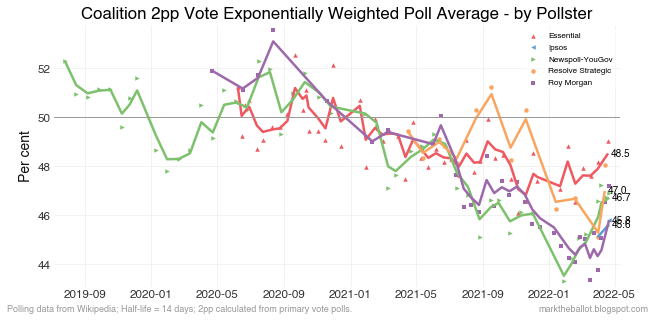

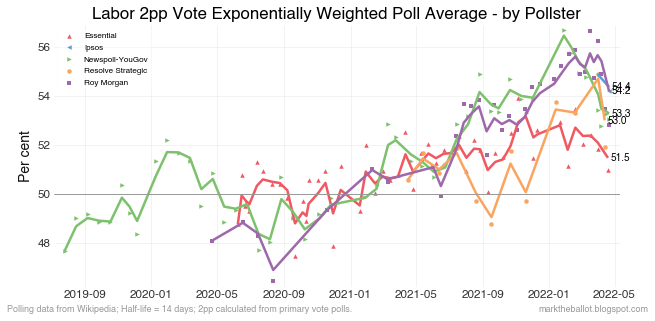

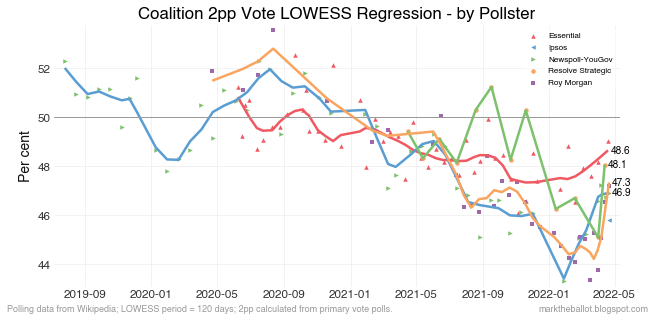

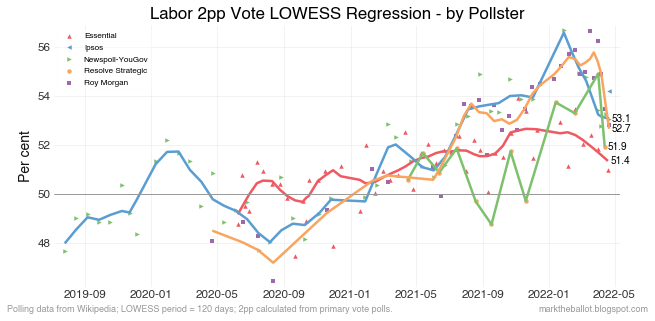

In [24]:
# 2pp ...
TPP_COLUMNS = ('Calculated 2pp L/NP', 'Calculated 2pp ALP')

llfooter = '; 2pp calculated from primary vote polls.'
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column in zip(TPP_PARTIES, TPP_COLUMNS):
        title = f'{party} 2pp Vote {stem} - by Pollster'
        common.plot_summary_line_by_pollster(df=pv, 
                                      column=column, 
                                      title=title,
                                      function=function, 
                                      argument=argument, 
                                      lfooter=lfooter+llfooter)        


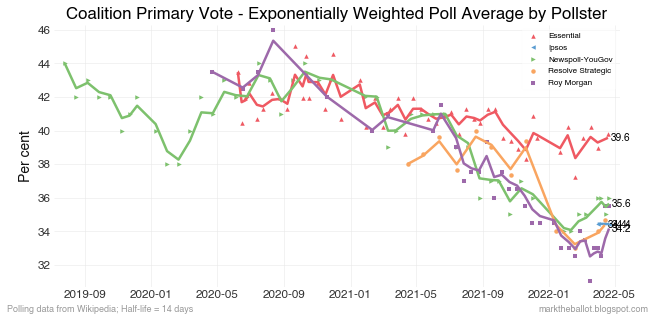

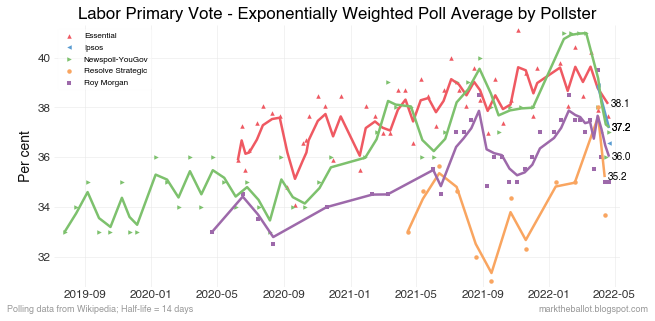

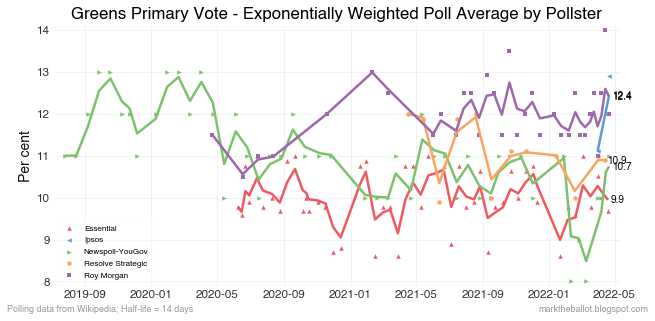

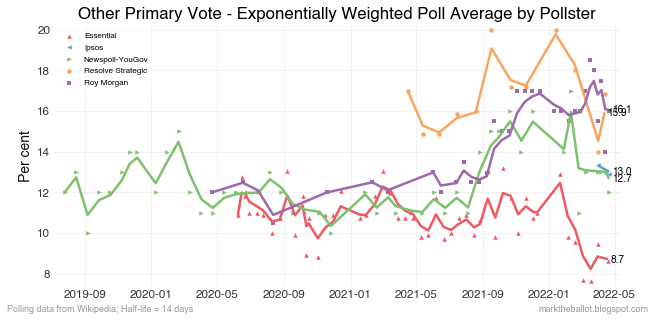

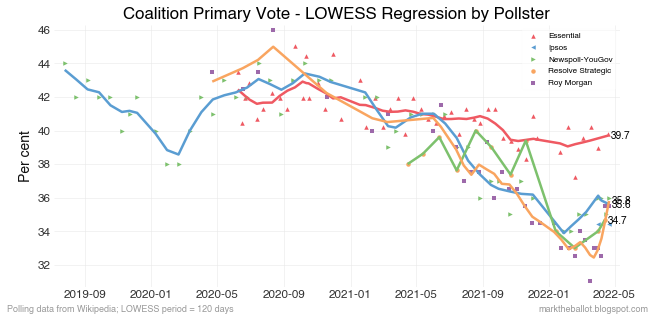

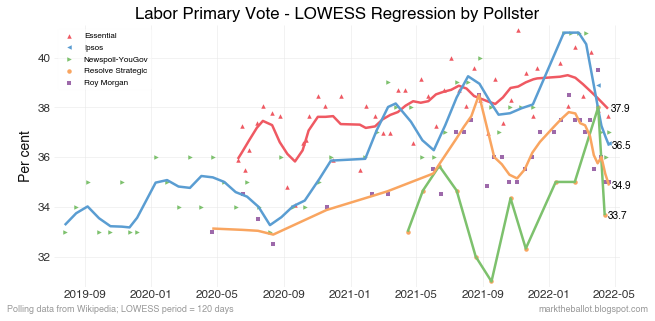

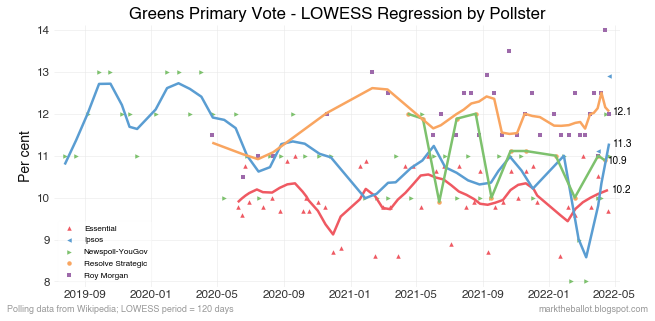

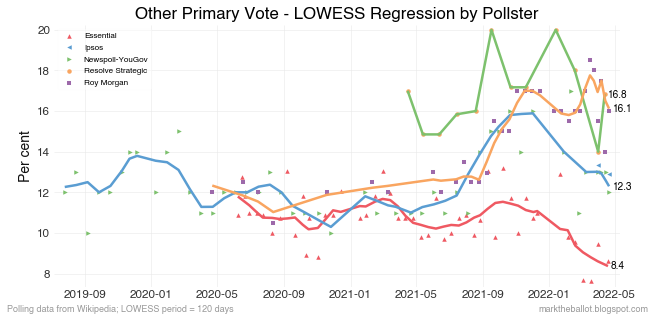

In [25]:
# primary votes ...
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column in zip(PARTIES, COLUMNS):
        title = f'{party} Primary Vote - {stem} by Pollster'
        common.plot_summary_line_by_pollster(df=pv, 
                                      column=column, 
                                      title=title,
                                      function=function, 
                                      argument=argument, 
                                      lfooter=lfooter)        

### All poll aggregations

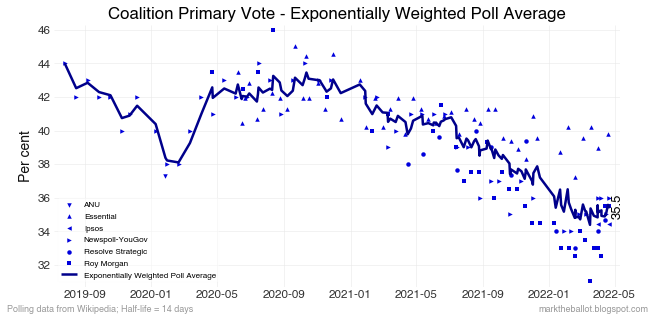

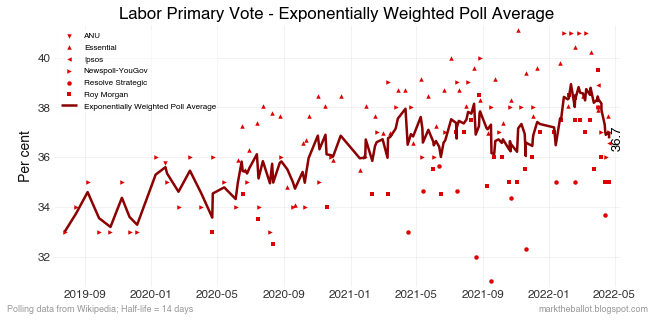

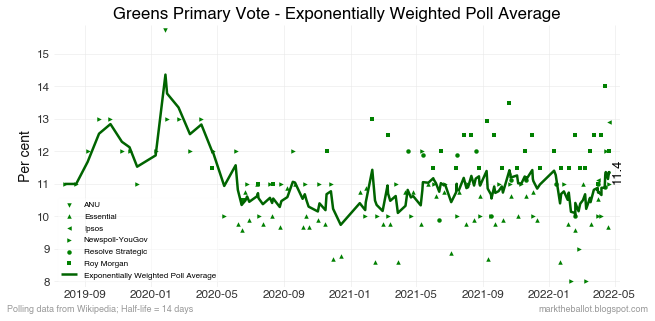

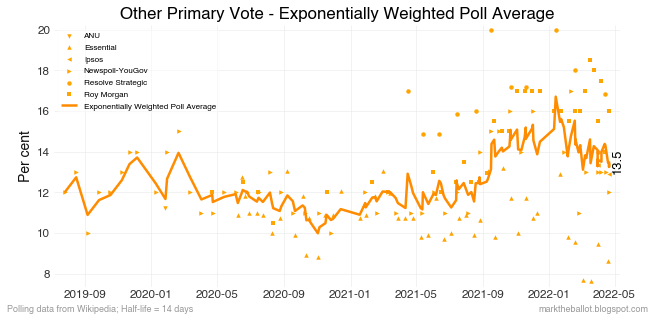

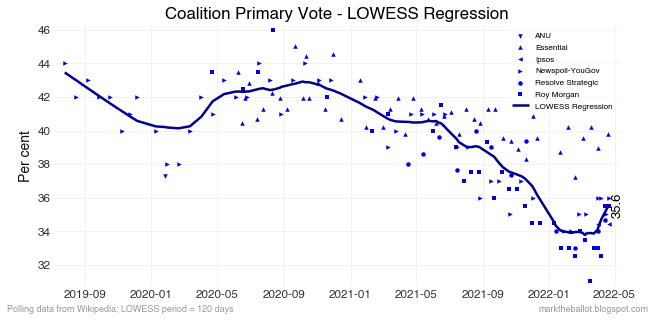

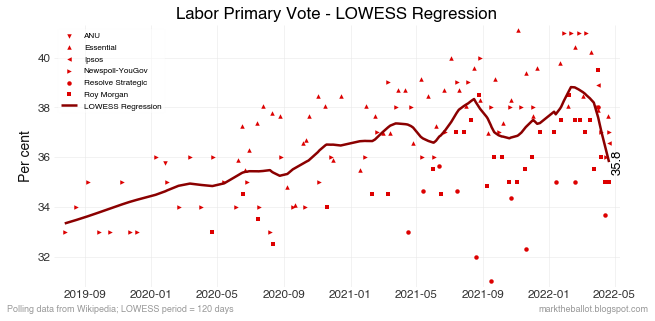

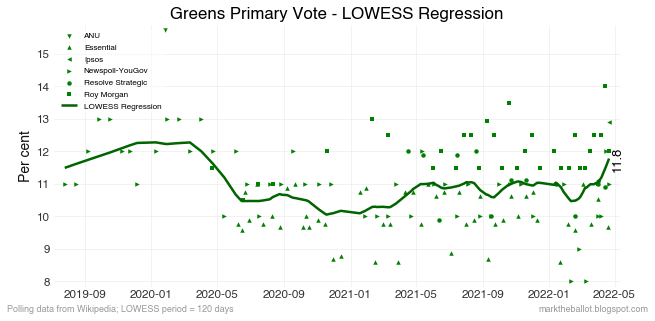

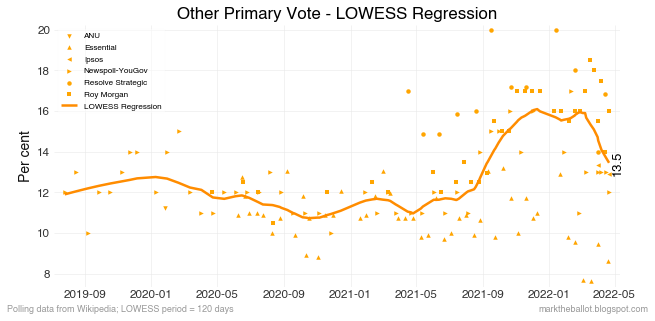

In [26]:
# primary votes ...
for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(PARTIES, COLUMNS, P_COLORS, L_COLORS):
        title = f'{party} Primary Vote - {stem}'
        common.plot_summary_line(df=pv, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter)


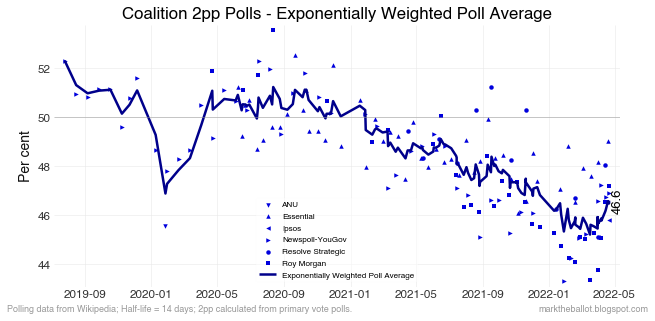

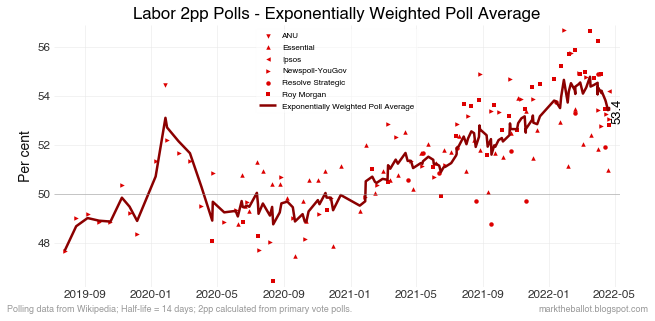

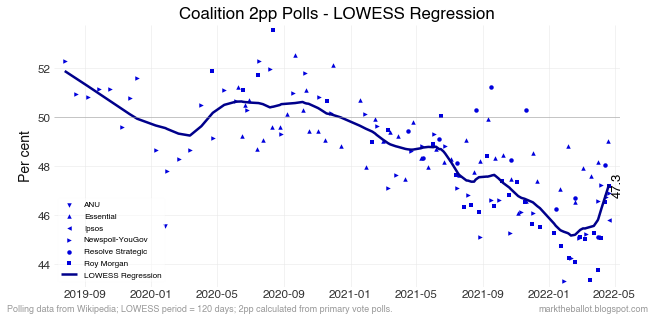

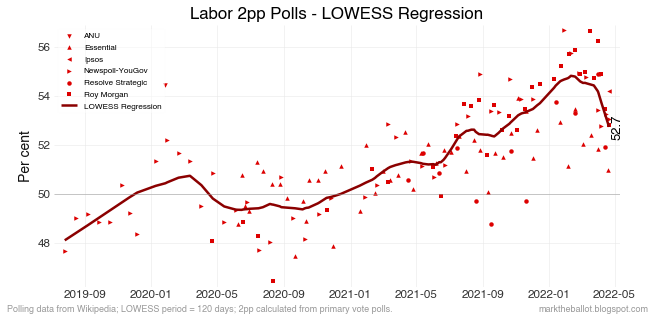

In [27]:
# 2pp, as calculated by me ...
TPP_COLUMNS = ('Calculated 2pp L/NP', 'Calculated 2pp ALP')
llfooter = '; 2pp calculated from primary vote polls.'

for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(TPP_PARTIES, TPP_COLUMNS, TPP_P_COLORS, TPP_L_COLORS):
        title = f'{party} 2pp Polls - {stem}'
        common.plot_summary_line(df=pv, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter+llfooter)

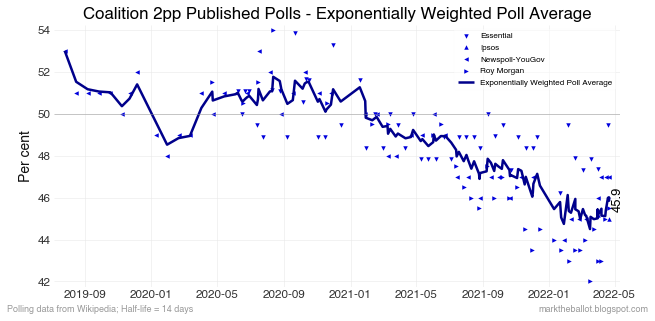

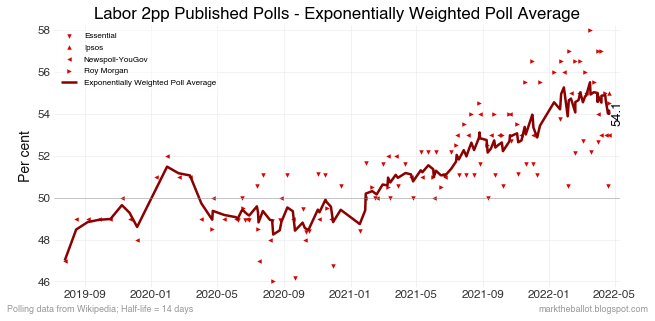

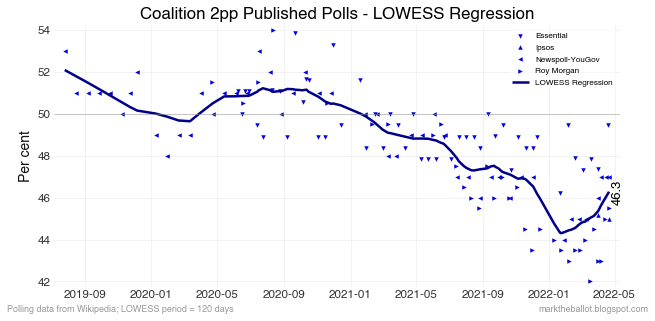

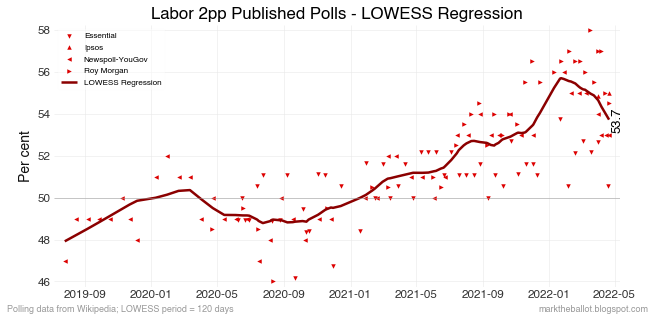

In [28]:
# 2pp, as published by pollsters ...
TPP_COLUMNS = ('2pp vote L/NP', '2pp vote ALP')

for function, argument, stem, lfooter in zip(FUNCTIONS, ARGUMENTS, TITLE_STEMS, LFOOTERS):
    for party, column, p_color, l_color in zip(TPP_PARTIES, TPP_COLUMNS, TPP_P_COLORS, TPP_L_COLORS):
        title = f'{party} 2pp Published Polls - {stem}'
        common.plot_summary_line(df=tpp, column=column, 
                      p_color=p_color, l_color=l_color, 
                      title=title,
                      function=function, 
                      argument=argument, 
                      label=stem, 
                      lfooter=lfooter)

### Preferred Prime Minister

In [29]:
ppm.columns

Index(['Mean Date', 'Date', 'Brand', 'Firm', 'Interview mode', 'Sample size',
       'Preferred Prime Minister Morrison',
       'Preferred Prime Minister Albanese',
       'Preferred Prime Minister Don't Know', 'Morrison Satisfied',
       'Morrison Dissatisfied', 'Morrison Don't Know', 'Albanese Satisfied',
       'Albanese Dissatisfied', 'Albanese Don't Know'],
      dtype='object')

In [30]:
def ppm_charts(df, columns, title):

    ax = None
    no_label = False
    fig, ax = common.initiate_plot()
    for col, (name, p_color, l_color) in columns.items():
        common.add_data_points_by_pollster(ax, df, col, p_color, no_label=no_label)
        no_label = True # avoid repeated labels
        lowess = common.calculate_lowess(ppm[col], ppm['Mean Date'], period=150)
        ax.plot(lowess.index, lowess, c=l_color, lw=2.5, label=name)
    common.add_h_refence(ax, reference=50)
    ax.legend(loc='best', ncol=2)
    common.plot_finalise(ax, ylabel='Per cent', title=title, lfooter=LFOOTER)

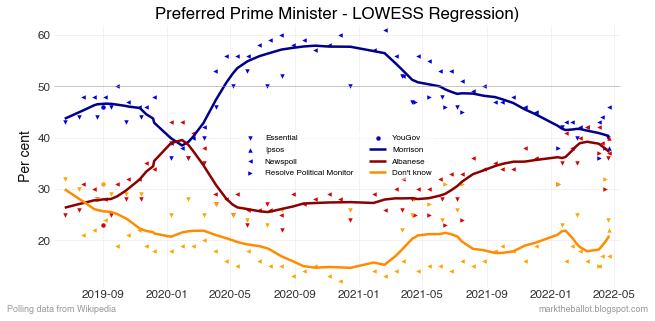

In [31]:
columns = {
    ('Preferred Prime Minister Morrison'): ['Morrison', P_COLOR_COALITION, COLOR_COALITION],    
    ('Preferred Prime Minister Albanese'): ['Albanese', P_COLOR_LABOR, COLOR_LABOR],    
    ("Preferred Prime Minister Don't Know"): ["Don't know", P_COLOR_OTHER, COLOR_OTHER],    
}

title = f'Preferred Prime Minister - LOWESS Regression)'
ppm_charts(ppm, columns, title)

### Satisfaction charts

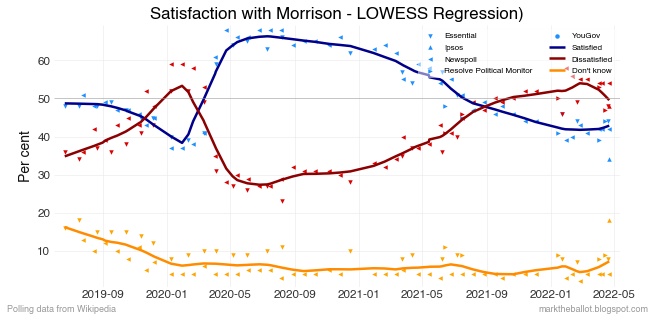

In [32]:
columns = {
    ('Morrison Satisfied'): ["Satisfied", 'dodgerblue', 'darkblue'],    
    ('Morrison Dissatisfied'): ["Dissatisfied", '#dd0000', 'darkred'],    
    ("Morrison Don't Know"): ["Don't know", 'orange', 'darkorange'],    
}

title = f'Satisfaction with Morrison - LOWESS Regression)'
ppm_charts(ppm, columns, title)

In [33]:
ppm

,Mean Date,Date,Brand,Firm,Interview mode,Sample size,Preferred Prime Minister Morrison,Preferred Prime Minister Albanese,Preferred Prime Minister Don't Know,Morrison Satisfied,Morrison Dissatisfied,Morrison Don't Know,Albanese Satisfied,Albanese Dissatisfied,Albanese Don't Know
0,2019-06-21,19–23 June 2019,Essential,Essential,Online,NaN,43.0,25.0,32.0,48.0,36.0,16.0,35.0,25.0,40.0
1,2019-07-19,17–21 July 2019,Essential,Essential,Online,NaN,44.0,26.0,30.0,48.0,34.0,18.0,39.0,24.0,37.0
2,2019-07-26,25–28 July 2019,Newspoll,YouGov,IVR/online,NaN,48.0,31.0,21.0,51.0,36.0,13.0,39.0,36.0,25.0
3,2019-08-16,15–18 August 2019,Newspoll,YouGov,IVR/online,NaN,48.0,30.0,22.0,48.0,42.0,10.0,41.0,34.0,25.0
4,2019-08-22,22 August 2019,Essential,Essential,Online,NaN,44.0,28.0,28.0,48.0,37.0,15.0,38.0,29.0,33.0
5,2019-09-01,1 September 2019,YouGov,YouGov,Online,NaN,46.0,23.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2019-09-06,5–7 September 2019,Newspoll,YouGov,IVR/online,NaN,48.0,28.0,24.0,49.0,39.0,12.0,35.0,40.0,25.0
7,2019-09-17,17 September 2019,Essential,Essential,Online,NaN,46.0,25.0,29.0,49.0,36.0,15.0,36.0,31.0,33.0
8,2019-09-29,29 September 2019,Newspoll,YouGov,IVR/online,NaN,50.0,31.0,19.0,47.0,43.0,10.0,39.0,40.0,21.0
9,2019-10-15,15 October 2019,Essential,Essential,Online,NaN,43.0,28.0,29.0,47.0,38.0,15.0,40.0,29.0,31.0


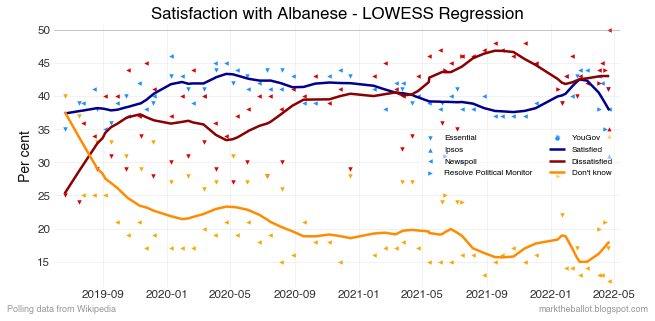

In [34]:
columns = {
    ('Albanese Satisfied'): ["Satisfied", 'dodgerblue', 'darkblue'],    
    ('Albanese Dissatisfied'): ["Dissatisfied", '#dd0000', 'darkred'],    
    ("Albanese Don't Know"): ["Don't know", 'orange', 'darkorange'],    
}

title = f'Satisfaction with Albanese - LOWESS Regression'
ppm_charts(ppm, columns, title)

## Save files

In [35]:
# and save to file
tpp.to_csv(f'{DATA_DIR}two_party_preferred.csv')
pv.to_csv(f'{DATA_DIR}primary_vote.csv')
ppm.to_csv(f'{DATA_DIR}preferred_prime_minister.csv')

## Check for any problems with data capture and cleaning

In [36]:
# Note you should go back and check any warnings that appear here ...
common.print_warnings()

  1: check_row_sums() found issues with 2pp vote
  2: check_row_sums() found issues with Primary vote
  3: check_row_sums() found issues with Preferred Prime Minister
  4: check_row_sums() found issues with Albanese
  5: final_sanity_check() found an issue with "2pp vote L/NP"
  6: final_sanity_check() found an issue with "2pp vote ALP"
  7: final_sanity_check() found an issue with "Primary vote L/NP"
  8: final_sanity_check() found an issue with "Primary vote OTH"
  9: There is a substantial mismatch with pollster 2pp at
	[datetime.date(2021, 11, 5)]
